In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Pendulum-v2')

In [11]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [27]:
alpha = 0.1
beta = .5

dummy_optimizer = Optimizer()

def gradient_old(state, next_state, actor, critic):
    params = actor.trainable_weights
    
    # q_func gradient tensor
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss, params)
    
    # discount factor gradient tensor
    discount = - tf.exp(- alpha * actor_output[0][1])
    gradient_for_d = dummy_optimizer.get_gradients(discount, params)
    next_state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    next_action = actor(next_state_input)
    next_value = critic([next_action, next_state_input])[0][0]
    gradient_for_d = [next_value * g for g in gradient_for_d]
    
    # gradient
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    
    # calc
    grad_calc_func = K.function([state_input, next_state_input], gradient_tensor)
    q_g = grad_calc_func([[state], [next_state]]) # ここに0.5sくらいかかる

    return q_g


def gradient_for_one_data(state, next_state, actor, critic):
    params = actor.trainable_weights  
    # q_func gradient tensor
    state_input = tf.constant([[state.tolist()]], tf.float32)
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss, params) # 300msくらいかかっちゃう
    
    # discount factor gradient tensor
    discount = - tf.exp(- alpha * actor_output[0][1])
    gradient_for_d = dummy_optimizer.get_gradients(discount, params)
    next_state_input = tf.constant([[next_state.tolist()]], tf.float32)
    next_action = actor(next_state_input)
    next_value = critic([next_action, next_state_input])[0][0]
    gradient_for_d = [next_value * g for g in gradient_for_d]
    
    gradient_for_one_state = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    
    return gradient_for_one_state

def gradient(states, next_states, actor, critic):
    batch_size = len(states)
    for i in range(batch_size):
        state, next_state = states[i], next_states[i]
        g_tensor = gradient_for_one_data(state, next_state, actor, critic)
        if i == 0:
            out = [tf.constant(0.)] * len(g_tensor)
            out = [K.add(o, g) / batch_size for o, g in zip(out, g_tensor)]
        else:
            out = [K.add(o, g) / batch_size for o, g in zip(out, g_tensor)]
    func = K.function([], out)
    gg = func([[]])
    return gg

# Adam クラス
def learning_rate_arr(actor, size=210, u_lr=.00001, tau_lr=.0001):
    grad_idx = 0
    i, j = 0, 0
    lrs = np.zeros((size,))
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            grad_idx += len(w.ravel()) + len(b.ravel())
            if j % 2 == 0: # u
                lrs[i:grad_idx] = u_lr
            else: # tau
                lrs[i:grad_idx] = tau_lr
            i = grad_idx
            j += 1
    return lrs

    
def flatten_gradient(gradient):
    params = []
    for i in range(len(gradient)//2):
        w, b = gradient[2*i], gradient[2*i+1]
        layer_params = np.hstack((w.ravel(), b.ravel()))
        params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params


def get_nn_params(actor):
    params = []
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            layer_params = np.hstack((w.ravel(), b.ravel()))
            params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params

def set_nn_params(actor, params):
    param_idx = 0
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            # set w
            w_prime = params[param_idx:param_idx+w.ravel().shape[0]].reshape(w.shape)
            param_idx += w.ravel().shape[0]

            # set b
            b_prime = params[param_idx:param_idx+b.ravel().shape[0]].reshape(b.shape)
            param_idx += b.ravel().shape[0]

            layer.set_weights([w_prime, b_prime])
    assert params.shape[0] == param_idx
    return actor

class Adam_original():
    def __init__(self, lrs, beta_1=.9, beta_2=.999, epsilon=1e-6):
        self.lrs = lrs # 学習率
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        self.m = np.zeros(210,) # 前回の勾配
        self.v = np.zeros(210,) # 前回の2乗勾配
    
    def update(self, actor, pg):
        # update m
        self.m = (self.beta_1 * self.m) + (1. - self.beta_1) * pg
        
        # update v
        self.v = (self.beta_2 * self.v) + (1. - self.beta_2) * pg**2
        
        # 更新量を決める
        ag = self.lrs * self.m / (np.sqrt(self.v) + self.epsilon)
        
        # 今のパラメータ
        ps = get_nn_params(actor)
        
        # update
        ps = ps - ag
        
        # update
        actor = set_nn_params(actor, ps)
    
        return actor

In [28]:
# 1ステップのインタラクション
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1


# 学習データ
def train_data(actor, noise=False):
    memory = []
    S1 = np.linspace(-7, 7, 20)
    S2 = np.linspace(-7, 7, 20)
    S1, S2 = np.meshgrid(S1, S2)
    S1, S2 = S1.flatten(), S2.flatten()
    
    ln = 1 if noise else 0
    n = 5 if noise else 1
    
    for _ in range(n):
        for i, x in enumerate(zip(S1, S2)):
            state0 = np.array(x)
            noise = np.array([np.random.randn() / 10., np.random.randn() / 100.])
            a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0] + ln*noise
            reward, state1 = interaction(state0, a_agent, tau, env, ln=0.1)
            memory.append([state0, np.array([a_agent, tau]), reward, state1])
    memory = np.array(memory)
    return memory

# Q関数の学習
def td_learning(memory, actor, critic, target_actor, target_critic, batch_size=32, epoch=5000):
    # TODO: loss小さい=関数として正しい　をチェックする
    assert critic.compile, 'compile critic before use this function'
    # critic learning
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = target_actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        target = target_critic.predict_on_batch(state1_batch_with_action)
        discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
        r_second = np.multiply(discount, target)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        
        losses.append(loss)
        
    return critic, losses

# 勾配の計算
def policy_gradient(actor, critic, init_state = np.array([3,3])):
    # 初期状態からのシミュレーション
    x = init_state
    episode_time = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.1)
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    
    # Q 関数の勾配を計算する
    tmp = []
    for i in range(len(log) - 1):
        tmp.append([log[i][0], log[i][1], log[i+1][0]])
    tmp = np.array(tmp)
    states, ts, next_states = tmp[:,0], tmp[:,1], tmp[:,2]
    pg = gradient(states, ts, next_states, actor, critic)
    pg = flatten_gradient(pg)
    return pg

def update_target_model(model, target_model, l=0.01):
    p = l * get_nn_params(model) + (1 - l) * get_nn_params(target_model)
    target_model = set_nn_params(target_model, p)
    return target_model

# 評価
def evaluation(actor, init_state = np.array([3,3])):
    x = init_state
    episode_time = 0
    episode_reward = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.)
        episode_reward += np.exp(- alpha * episode_time) * reward
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    return episode_reward

In [29]:
# replay buffer の実装
class replay_buffer():
    def __init__(self, n_limits=30000):
        self.n_limits = n_limits
        self.memory = []
        
    def store(self, experience):
        # (s, a, r, s', e^-at)
        assert len(experience) == 5, 'shape error'
        self.memory.append(experience)
        if len(self.memory) >= self.n_limits:
            del self.memory[0]
        
    def sample(self, batch_size):
        batch = []
        idx_log = []
        while len(batch) < batch_size:
            idx = np.random.choice(range(len(self.memory)))
            candidate = self.memory[idx]
            if idx in idx_log:
                continue
            if np.random.rand() < candidate[-1]:
                idx_log.append(idx)
                batch.append(candidate)
        assert len(batch) == batch_size, ''
        return np.array(batch)

In [30]:
actor = branch_actor((2,),(2,))
critic = critic_net((2,),(2,))[0]
target_actor = branch_actor((2,),(2,))
target_critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
target_critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')

In [31]:
actor.load_weights('../saved_agent/learned_self_clipped_actor.h5')
critic.load_weights('../saved_agent/learned_self_clipped_critic_l.h5')
target_actor.load_weights('../saved_agent/learned_self_clipped_actor.h5')
target_critic.load_weights('../saved_agent/learned_self_clipped_critic_l.h5')
lrs = learning_rate_arr(actor, size=210, u_lr=.0001, tau_lr=.001)
opt = Adam_original(lrs)
ev = evaluation(actor)

In [32]:
print(f'value_function for initial policy = {ev}')

s = np.random.uniform(-7,7,2)
episode_time = 0
time_limit = 10.
batch_size = 16
buffer = replay_buffer(n_limits=30000)
n_warm_up = 1000
ev_log = [ev]
for i in range(1100):
    u, tau = actor.predict_on_batch(s.reshape(1,1,2))[0]
    r, s_prime = interaction(s, u, tau, env, ln=0.1)
    buffer.store([s, np.array([u, tau]), r, s_prime, np.exp(- alpha * episode_time)])
    episode_time += tau
    s = s_prime
    if episode_time >= time_limit:
        s = np.random.uniform(-7,7,2)
        episode_time = 0
    if i < n_warm_up:
        continue
    print(f'{i-n_warm_up}-step')
    batch = buffer.sample(batch_size)
    critic, losses = td_learning(batch[:,:4], actor, critic, target_actor, target_critic, batch_size=batch_size, epoch=1)
    pg = flatten_gradient(gradient(batch[:,0], batch[:,3], actor, critic))
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    ev = evaluation(actor)
    ev_log.append(ev)
    target_actor = update_target_model(actor, target_actor)
    target_critic = update_target_model(critic, target_critic)
    print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    print(f'|g| = {np.linalg.norm(pg)}')

value_function for initial policy = -49.25818715854261
0-step
loss of critic is 105.89337158203125, value_fuction V(s) = -53.738557969690675
|g| = 1.159620821149278
1-step
loss of critic is 97.12177276611328, value_fuction V(s) = -52.734632854479216
|g| = 3.6596142668147476
2-step
loss of critic is 93.79509735107422, value_fuction V(s) = -44.660425828144646
|g| = 0.9417830892065379
3-step
loss of critic is 45.628700256347656, value_fuction V(s) = -51.50991305189328
|g| = 2.8087261787034836
4-step
loss of critic is 45.868412017822266, value_fuction V(s) = -41.181960525492705
|g| = 8.097379391315627
5-step
loss of critic is 55.44102096557617, value_fuction V(s) = -46.957882604062334
|g| = 8.468886734173058
6-step
loss of critic is 48.857643127441406, value_fuction V(s) = -41.53364454974754
|g| = 1.9136001289552755
7-step
loss of critic is 45.045249938964844, value_fuction V(s) = -38.393345476513865
|g| = 1.2949634722330763
8-step
loss of critic is 31.601608276367188, value_fuction V(s) =

KeyboardInterrupt: 

In [37]:
env.reset()
# actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
# actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
initial_state = np.array([3., 3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    tau = np.clip(tau, .01, 10.)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=.1)
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,2))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

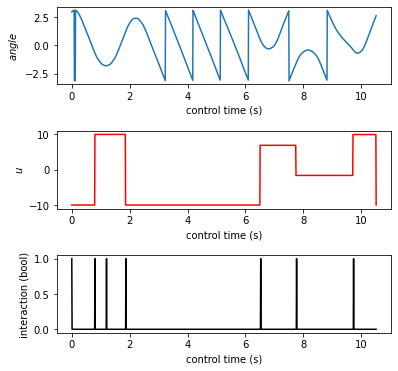

In [38]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$angle$')
plt.plot(detail_time_log, detail_states[:,0])
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [36]:
actor.save_weights('../saved_agent/learned_self_proposed0_actor.h5')
critic.save_weights('../saved_agent/learned_self_proposed0_critic.h5')